**Student name: Giorgi Guledani**

**Student ID: 20193667**

# Lecture 4: Research 1: How to address the Long Tail Problem?

In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

articles = pd.read_parquet(f'{utils.path}/articles.parquet')
customers = pd.read_parquet(f'{utils.path}/customers.parquet')
transactions = pd.read_parquet(f'{utils.path}/transactions_train.parquet')

# Parameters

In [2]:
# max items to replace Short Head items with Long Tail items
K_items = 10 

# Identifying short head and long tail items

In [3]:

# Determine the threshold for the top half
transactions_count = transactions.groupby(["article_id"])["article_id"].value_counts(dropna=False)
if not "long_tail" in articles.columns:
    articles = articles.merge(transactions.groupby(['article_id'])["article_id"].value_counts(dropna=False), left_on ="article_id", how="left", right_index=True)
    articles["count"].fillna(0, inplace=True)
    articles = articles.rename(columns={"count": "sales_count"})
    threshold = articles["sales_count"].median()
    print(f"Threshold (alpha): {threshold}")
    articles["long_tail"] = (articles["sales_count"] <= threshold).astype(int)
transactions[transactions["article_id"] == 351484039]


Threshold (alpha): 63.0


,t_dat,customer_id,article_id,price,sales_channel_id,week
22279468,2020-02-12,7993556869309464686,351484039,0.022017,2,73
22307079,2020-02-13,11693170829426928559,351484039,0.022017,2,73
22326267,2020-02-13,14251597971675452778,351484039,0.022017,2,73
22333826,2020-02-14,11322089096702754811,351484039,0.022017,2,73
22333814,2020-02-14,17298776028320583102,351484039,0.019814,2,73
...,...,...,...,...,...,...
31773893,2020-09-22,13118523669876511337,351484039,0.022017,2,104
31780827,2020-09-22,15473878317449867690,351484039,0.022017,2,104
31757413,2020-09-22,16551754216385484410,351484039,0.022017,2,104
31757898,2020-09-22,17214430568995933187,351484039,0.011000,1,104


According to a paper, setting the threshold in the middle gave the best results, which is why I set it as the median of all counts.

In [4]:
articles["long_tail"].value_counts()

long_tail
1    52921
0    52621
Name: count, dtype: int64

Items below the threshold get classified as long tail:

In [5]:
sorted_articles = articles[["article_id", "sales_count"]].sort_values(by="sales_count", ascending=False)

sorted_articles.reset_index(drop=True, inplace=True)
sorted_articles

,article_id,sales_count
0,706016001,50287.0
1,706016002,35043.0
2,372860001,31718.0
3,610776002,30199.0
4,759871002,26329.0
...,...,...
105537,926010001,0.0
105538,896195002,0.0
105539,917203001,0.0
105540,917203003,0.0


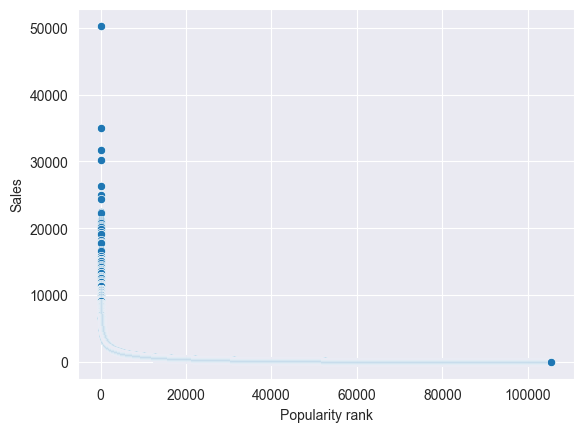

,article_id,sales_count
0,706016001,50287.0
1,706016002,35043.0
2,372860001,31718.0
3,610776002,30199.0
4,759871002,26329.0
...,...,...
105537,926010001,0.0
105538,896195002,0.0
105539,917203001,0.0
105540,917203003,0.0


In [6]:
sns.scatterplot(y=sorted_articles["sales_count"], x=sorted_articles.index)
# plt.gca().invert_xaxis()  # To reverse the x-axis

plt.xlabel("Popularity rank")
plt.ylabel("Sales")
plt.show()

plt.show()
sorted_articles

The scatterplot shows us that there's a select few in the short head part, while a huge amount is in the long tail part.

# Radek's preprocessing

In this section, I will be swapping Short Head candidates with Long Tail ones 

In [7]:
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

## Generating candidates

### Last purchase candidates

In [8]:
%%time

c2weeks = transactions.groupby('customer_id')['week'].unique()

CPU times: total: 10.7 s
Wall time: 10.8 s


In [9]:
transactions.groupby('week')['t_dat'].agg(['min', 'max'])


,min,max
week,,
95,2020-07-15,2020-07-21
96,2020-07-22,2020-07-28
97,2020-07-29,2020-08-04
98,2020-08-05,2020-08-11
99,2020-08-12,2020-08-18
100,2020-08-19,2020-08-25
101,2020-08-26,2020-09-01
102,2020-09-02,2020-09-08
103,2020-09-09,2020-09-15


In [10]:
c2weeks

customer_id
28847241659200          [95, 96, 101, 102]
41318098387474                        [98]
116809474287335                 [101, 103]
200292573348128          [95, 96, 99, 102]
248294615847351                       [96]
                               ...        
18446624797007271432                  [95]
18446630855572834764                 [103]
18446662237889060501                 [100]
18446705133201055310                 [102]
18446737527580148316                 [104]
Name: week, Length: 437365, dtype: object

In [11]:
%%time

c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

CPU times: total: 375 ms
Wall time: 376 ms


In [12]:
c2weeks2shifted_weeks[28847241659200]

{95: 96, 96: 101, 101: 102, 102: 105}

In [13]:
candidates_last_purchase = transactions.copy()


In [14]:
%%time

weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week=weeks

CPU times: total: 13.2 s
Wall time: 13.2 s


In [15]:
candidates_last_purchase[candidates_last_purchase['customer_id']==272412481300040]

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,96
29030504,2020-07-15,272412481300040,816592008,0.016932,1,96
29030505,2020-07-15,272412481300040,621381021,0.033881,1,96
29030506,2020-07-15,272412481300040,817477003,0.025407,1,96
29030507,2020-07-15,272412481300040,899088002,0.025407,1,96
29319533,2020-07-22,272412481300040,885077001,0.008458,1,103
29410772,2020-07-24,272412481300040,850176003,0.029034,2,103
29410773,2020-07-24,272412481300040,875803001,0.064559,2,103
29410774,2020-07-24,272412481300040,892970003,0.020966,2,103
29410775,2020-07-24,272412481300040,854619003,0.020966,2,103


In [16]:
transactions[transactions['customer_id']==272412481300040]

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95
29319533,2020-07-22,272412481300040,885077001,0.008458,1,96
29410772,2020-07-24,272412481300040,850176003,0.029034,2,96
29410773,2020-07-24,272412481300040,875803001,0.064559,2,96
29410774,2020-07-24,272412481300040,892970003,0.020966,2,96
29410775,2020-07-24,272412481300040,854619003,0.020966,2,96


### Bestsellers candidates

In [17]:
mean_price = transactions \
.groupby(['week', 'article_id'])['price'].mean()

In [18]:
mean_price

week  article_id
95    108775015     0.004729
      108775044     0.008458
      110065001     0.006085
      110065002     0.006085
      111565001     0.004288
                      ...   
104   952267001     0.013732
      952938001     0.048651
      953450001     0.016932
      953763001     0.021885
      956217002     0.059068
Name: price, Length: 196880, dtype: float32

In [19]:
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')

In [20]:
sales

week  article_id
95    760084003      1
      866731001      2
      600886001      3
      706016001      4
      372860002      5
                    ..
104   915529003      8
      915529005      9
      448509014     10
      762846027     11
      714790020     12
Name: bestseller_rank, Length: 120, dtype: int8

In [21]:
sales_frame = sales.to_frame().reset_index() # DataFrame is easier to use than Series (from Radek), so I'll use this from now on

### Diversity before

I'll measure diversity using Jaccard index

In [22]:
def jaccard_diversity(list1, list2):
    intersection = len(list1.intersection(list2))
    union = len(list1.union(list2))
    jaccard_index = intersection / union
    diversity_index = 1 - jaccard_index
    return diversity_index

def avg_jaccard_diversity(df, weeks_list): # only computes diversity with next week (chain)
    jaccard_sum = 0
    pair_count = 0
    
    for i, week1 in enumerate(weeks_list):
        article_ids1 = set(df[df["week"] == week1]["article_id"])
        if week1 == weeks_list.max():
            break
        week2 = week1 + 1
        article_ids2 = set(df[df["week"] == week2]["article_id"])
        diversity_index = jaccard_diversity(article_ids1, article_ids2)
        print(f"{week1}, {week2}: {diversity_index}")
        jaccard_sum += diversity_index
        pair_count += 1
    average_jaccard = jaccard_sum / pair_count
    print(f"Average diversity: {average_jaccard}")


weeks_list = sales_frame["week"].unique()

avg_jaccard_diversity(sales_frame, weeks_list)

95, 96: 0.736842105263158
96, 97: 0.8571428571428572
97, 98: 1.0
98, 99: 1.0
99, 100: 0.8
100, 101: 0.736842105263158
101, 102: 0.5882352941176471
102, 103: 0.8571428571428572
103, 104: 0.5882352941176471
Average diversity: 0.7960489458941472


In [23]:
sales_frame

,week,article_id,bestseller_rank
0,95,760084003,1
1,95,866731001,2
2,95,600886001,3
3,95,706016001,4
4,95,372860002,5
...,...,...,...
115,104,915529003,8
116,104,915529005,9
117,104,448509014,10
118,104,762846027,11


### Increasing diversity

We see that there only is a diversity of almost 80%. I'll use the most popular candidates from Long Tail to replace K Short Head items

We can see that currently there is not a single Long Tail candidate:

In [24]:
sales_frame.merge(articles[["article_id", "long_tail"]], on ="article_id", how="left")["long_tail"].value_counts()

long_tail
0    120
Name: count, dtype: int64

This means that when we replace a short head item, diversity is bound to increase (assuming we don't recommend the same Long Tail item twice within 2 weeks)

In [25]:
def increase_diversity(df, weeks_list, K):
    top_long_tail = articles[articles["long_tail"]==1][["article_id", "sales_count"]].head(200).sort_values(by="sales_count", ascending=False)
    top_long_tail.reset_index(inplace=True)
    long_tail_index = 0 # start from most popular
    for i, week1 in enumerate(weeks_list):
        article_ids1 = set(df[df["week"] == week1]["article_id"])
        if week1 == weeks_list.max():
            break
        week2 = week1 + 1
        items_left = K
        article_ids2 = set(df[df["week"] == week2]["article_id"])
        curr_diversity_index = jaccard_diversity(article_ids1, article_ids2)
        
        for j, item in df[df["week"]==week1].iterrows(): # edit items one by one until K items edited or diversity maximized
            if items_left == 0:
                break
            old_item = df.at[j, "article_id"]
            new_item = top_long_tail.at[long_tail_index, "article_id"]
            df.at[j, "article_id"] = new_item
            items_left -= 1
            long_tail_index += 1
            diversity_index = jaccard_diversity(article_ids1, article_ids2) # diversity is always going to increase, because it contains no long tail items
            if diversity_index == 1.0 or items_left == 0: # good, no replacement needed
                break
    return df

sales_frame = increase_diversity(sales_frame, weeks_list, K=K_items)

sales_frame

,week,article_id,bestseller_rank
0,95,150959013,1
1,95,146721001,2
2,95,176209025,3
3,95,156610010,4
4,95,213691001,5
...,...,...,...
115,104,915529003,8
116,104,915529005,9
117,104,448509014,10
118,104,762846027,11


Now we can see an improvement in diversity:

In [26]:
avg_jaccard_diversity(sales_frame, weeks_list)

95, 96: 1.0
96, 97: 1.0
97, 98: 1.0
98, 99: 1.0
99, 100: 1.0
100, 101: 1.0
101, 102: 1.0
102, 103: 1.0
103, 104: 0.9565217391304348
Average diversity: 0.995169082125604


In [27]:
bestsellers_previous_week = pd.merge(sales_frame, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1

In [28]:
bestsellers_previous_week.pipe(lambda df: df[df['week']==96])

,index,week,article_id,bestseller_rank,price
0,0,96,866731003,11,0.024893
1,1,96,866383006,12,0.023195


In [29]:
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()

In [30]:
unique_transactions

,t_dat,customer_id,sales_channel_id,week
29030503,2020-07-15,272412481300040,1,95
29064059,2020-07-15,1456826891333599,1,95
29067103,2020-07-15,2133687643102426,2,95
29027487,2020-07-15,6010692573790711,1,95
29046403,2020-07-15,6171059100114610,2,95
...,...,...,...,...
31760188,2020-09-22,18435221511488011015,1,104
31782234,2020-09-22,18436859303155335645,1,104
31787251,2020-09-22,18437941771381362708,2,104
31776022,2020-09-22,18438270306572912089,1,104


In [31]:
transactions.drop_duplicates(['week', 'customer_id'])

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29064059,2020-07-15,1456826891333599,888294001,0.013542,1,95
29067103,2020-07-15,2133687643102426,843642001,0.042356,2,95
29027487,2020-07-15,6010692573790711,857812010,0.039661,1,95
29046403,2020-07-15,6171059100114610,815447007,0.006763,2,95
...,...,...,...,...,...,...
31760188,2020-09-22,18435221511488011015,573085055,0.033881,1,104
31782234,2020-09-22,18436859303155335645,801447001,0.030492,1,104
31787251,2020-09-22,18437941771381362708,907188001,0.050831,2,104
31776022,2020-09-22,18438270306572912089,751471043,0.033881,1,104


In [32]:
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week',
)
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,price
0,2020-07-22,200292573348128,2,96,0,866731003,11,0.024893
1,2020-07-22,200292573348128,2,96,1,866383006,12,0.023195
2,2020-07-22,248294615847351,1,96,0,866731003,11,0.024893
3,2020-07-22,248294615847351,1,96,1,866383006,12,0.023195
4,2020-07-22,272412481300040,1,96,0,866731003,11,0.024893
...,...,...,...,...,...,...,...,...
2822492,2020-09-22,18437941771381362708,2,104,37,923758001,12,0.033478
2822493,2020-09-22,18438270306572912089,1,104,36,673677002,11,0.024925
2822494,2020-09-22,18438270306572912089,1,104,37,923758001,12,0.033478
2822495,2020-09-22,18440902715633436014,1,104,36,673677002,11,0.024925


In [33]:
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [34]:
test_set_transactions

,t_dat,customer_id,sales_channel_id,week
0,2020-07-15,272412481300040,1,105
1,2020-07-15,1456826891333599,1,105
2,2020-07-15,2133687643102426,2,105
3,2020-07-15,6010692573790711,1,105
4,2020-07-15,6171059100114610,2,105
...,...,...,...,...
437360,2020-09-22,18410229429441241008,2,105
437361,2020-09-22,18417769707947924979,2,105
437362,2020-09-22,18418054986721795659,2,105
437363,2020-09-22,18421175435799911749,2,105


In [35]:
bestsellers_previous_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            50 non-null     int64  
 1   week             50 non-null     int8   
 2   article_id       50 non-null     int32  
 3   bestseller_rank  50 non-null     int8   
 4   price            50 non-null     float32
dtypes: float32(1), int32(1), int64(1), int8(2)
memory usage: 1.0 KB


In [36]:
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)

Bestsellers from test week get added to bestseller candidates of training weeks

In [37]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [38]:
candidates_bestsellers
# candidates_bestsellers[candidates_bestsellers["article_id"] == 938182001]


,t_dat,customer_id,sales_channel_id,week,index,article_id,price
0,2020-07-22,200292573348128,2,96,0,866731003,0.024893
1,2020-07-22,200292573348128,2,96,1,866383006,0.023195
2,2020-07-22,248294615847351,1,96,0,866731003,0.024893
3,2020-07-22,248294615847351,1,96,1,866383006,0.023195
4,2020-07-22,272412481300040,1,96,0,866731003,0.024893
...,...,...,...,...,...,...,...
5248375,2020-09-22,18438270306572912089,1,105,45,915529003,0.033439
5248376,2020-09-22,18438270306572912089,1,105,46,915529005,0.033417
5248377,2020-09-22,18438270306572912089,1,105,47,448509014,0.041630
5248378,2020-09-22,18438270306572912089,1,105,48,762846027,0.025005


Article info gets added to bestseller candidates

In [39]:
candidates_bestsellers = candidates_bestsellers.merge(articles[["article_id", "long_tail", "sales_count"]], on="article_id", how="left")
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,index,article_id,price,long_tail,sales_count
0,2020-07-22,200292573348128,2,96,0,866731003,0.024893,0,1375.0
1,2020-07-22,200292573348128,2,96,1,866383006,0.023195,0,4158.0
2,2020-07-22,248294615847351,1,96,0,866731003,0.024893,0,1375.0
3,2020-07-22,248294615847351,1,96,1,866383006,0.023195,0,4158.0
4,2020-07-22,272412481300040,1,96,0,866731003,0.024893,0,1375.0
...,...,...,...,...,...,...,...,...,...
8070872,2020-09-22,18438270306572912089,1,105,45,915529003,0.033439,0,2697.0
8070873,2020-09-22,18438270306572912089,1,105,46,915529005,0.033417,0,856.0
8070874,2020-09-22,18438270306572912089,1,105,47,448509014,0.041630,0,19216.0
8070875,2020-09-22,18438270306572912089,1,105,48,762846027,0.025005,0,1260.0


# Combining transactions and candidates / negative examples


In [40]:
transactions['purchased'] = 1


In [41]:
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data.purchased.fillna(0, inplace=True)

In [42]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,index,long_tail,sales_count
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0,NaN,NaN,NaN
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0,NaN,NaN,NaN
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0,NaN,NaN,NaN
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0,NaN,NaN,NaN
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8070872,2020-09-22,18438270306572912089,915529003,0.033439,1,105,0.0,45.0,0.0,2697.0
8070873,2020-09-22,18438270306572912089,915529005,0.033417,1,105,0.0,46.0,0.0,856.0
8070874,2020-09-22,18438270306572912089,448509014,0.041630,1,105,0.0,47.0,0.0,19216.0
8070875,2020-09-22,18438270306572912089,762846027,0.025005,1,105,0.0,48.0,0.0,1260.0


In [43]:
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [44]:
data.purchased.mean()


0.19145887405044987

### Add bestseller information


In [45]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [46]:
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)

In [47]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [48]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [49]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [50]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [51]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [52]:
%%time

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

CPU times: total: 172 ms
Wall time: 173 ms


In [53]:
# Model training


In [54]:
from lightgbm.sklearn import LGBMRanker

In [55]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [56]:
%%time

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.110149
[LightGBM] [Debug] init for col-wise cost 0.000019 seconds, init for row-wise cost 0.160493 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 6101375, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
CPU times: total: 12.1 s
Wall time: 2.32 s


In [57]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.996693283714759
age 0.0009898252975102466
article_id 0.0006328531011281351
postal_code 0.000395100770146758
club_member_status 0.00037221787482013196
department_no 0.0002597253314254633
Active 0.00019288863474224455
colour_group_code 0.00016829179321106778
product_type_no 0.00016582458563520075
garment_group_no 9.340582950725811e-05
fashion_news_frequency 3.658306711450939e-05
FN 0.0
section_no 0.0
index_code 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
graphical_appearance_no 0.0
index_group_no 0.0


# Calculate predictions

In [58]:
%time

test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

CPU times: total: 0 ns
Wall time: 0 ns


In [59]:
bestsellers_last_week

[924243001,
 924243002,
 918522001,
 923758001,
 866731001,
 909370001,
 751471001,
 915529003,
 915529005,
 448509014,
 762846027,
 714790020]

# Create submission

In [60]:
sub = pd.read_csv(utils.path + "sample_submission.csv")

In [61]:
%%time
preds = []
for c_id in utils.customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

CPU times: total: 2.88 s
Wall time: 2.87 s


In [62]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [63]:
sub_name = "basic_model_submission_K" + str(K_items) + ".csv.gz"
sub.to_csv(f"{sub_name}", index=False)

# Evaluation (extra)

In [64]:
from create_validation import create_validation
create_validation()

### MAP@12 score

In [65]:
from evaluation import eval_sub_MAP

MAP12_score = eval_sub_MAP(sub_name)
print(sub_name)
print(MAP12_score)

basic_model_submission_K10.csv.gz
0.9249087213223713
